# Feature Engineering and Selection

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-модулей" data-toc-modified-id="Импорт-модулей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт модулей</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Оценка-базовой-модели" data-toc-modified-id="Оценка-базовой-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка базовой модели</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Cross validation</a></span></li><li><span><a href="#Model-tuning" data-toc-modified-id="Model-tuning-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model tuning</a></span></li></ul></li><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание новых признаков</a></span><ul class="toc-item"><li><span><a href="#Title" data-toc-modified-id="Title-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>Title</code></a></span></li><li><span><a href="#Удаление-PassengerId-и-Name" data-toc-modified-id="Удаление-PassengerId-и-Name-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Удаление <code>PassengerId</code> и <code>Name</code></a></span></li><li><span><a href="#Индикатор-пропуска-для-Age-и-Cabin" data-toc-modified-id="Индикатор-пропуска-для-Age-и-Cabin-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Индикатор пропуска для <code>Age</code> и <code>Cabin</code></a></span></li><li><span><a href="#Заполнение-пропусков" data-toc-modified-id="Заполнение-пропусков-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Заполнение пропусков</a></span></li><li><span><a href="#Добавление-логарифмов-признаков-Age,-Fare" data-toc-modified-id="Добавление-логарифмов-признаков-Age,-Fare-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Добавление логарифмов признаков <code>Age</code>, <code>Fare</code></a></span></li><li><span><a href="#Дискретизация-количественных-признаков" data-toc-modified-id="Дискретизация-количественных-признаков-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Дискретизация количественных признаков</a></span></li><li><span><a href="#Вычисление-статистик-для-категориальных-переменных" data-toc-modified-id="Вычисление-статистик-для-категориальных-переменных-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Вычисление статистик для категориальных переменных</a></span></li></ul></li></ul></div>

## Импорт модулей

In [1]:
from catboost import CatBoostClassifier, Pool, metrics, cv

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.imputation import AddMissingIndicator, RandomSampleImputer
from feature_engine.transformation import LogCpTransformer

from joblib import load
from matplotlib import pyplot as plt
import numpy as np
import optuna
from optuna.integration import CatBoostPruningCallback
import pandas as pd
import shap
import sklearn
from sklearn.preprocessing import FunctionTransformer

CV=5

sklearn.set_config(transform_output="pandas")

%matplotlib inline

## Загрузка данных

In [2]:
X_train, y_train = load("train_set.joblib")

## Оценка базовой модели

### Cross validation

In [3]:
train_pool = Pool(
    data=X_train.fillna(-999),
    label=y_train, 
    cat_features=['PassengerId', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked'],
    text_features=['Name']
)

model_params = dict(
    loss_function = metrics.Logloss(),
    custom_loss=[metrics.Accuracy(), metrics.AUC()],
)

cv_data = cv(
    pool=train_pool, 
    params=model_params, 
    logging_level='Silent', 
    plot=True,
    nfold=CV,
)

best_id = np.argmax(cv_data['test-Accuracy-mean'])

print(f"Best mean accuracy: {np.round(cv_data['test-Accuracy-mean'][best_id], 3)}")
print(f"Accuracy std: {np.round(cv_data['test-Accuracy-std'][best_id], 4)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best mean accuracy: 0.843
Accuracy std: 0.0415


### Model tuning

In [ ]:
def objective(trial):
    
    model_params = dict(
        loss_function = metrics.Logloss(),
        custom_loss=[metrics.Accuracy(), metrics.AUC()],
    )
    
    cv_data = cv(
        pool=train_pool, 
        params=model_params, 
        logging_level='Silent', 
        plot=True,
        nfold=CV,
    )

    best_id = np.argmax(cv_data['test-Accuracy-mean'])

    print(f"Best mean accuracy: {np.round(cv_data['test-Accuracy-mean'][best_id], 3)}")
    print(f"Accuracy std: {np.round(cv_data['test-Accuracy-std'][best_id], 4)}")

## Создание новых признаков

In [4]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            137
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          552
Embarked         2
dtype: int64

In [5]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


### `Title`

In [6]:
def add_title(X, y=None, group_rare=True):
    title = X.Name.str.extract(pat=r"\b,\s(.+?)\.\s[\b(]?")
    title = pd.Series(title[0], name="Title").str.lower()

    if group_rare:
        title = title.where(
            title.isin(["mr", "miss", "mrs", "master"]), "aristocratic"
        )

    return pd.concat([X, title], axis="columns")

title_adder = FunctionTransformer(add_title)


X_train = title_adder.fit_transform(X_train)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,mr
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,mr
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,mr
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,mrs
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,mrs


### Удаление `PassengerId` и `Name`

In [7]:
title_adder = FunctionTransformer(
    lambda x: x.drop(columns=['PassengerId', 'Name'])
)

X_train = title_adder.fit_transform(X_train)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
692,3,male,NaN,0,0,1601,56.4958,NaN,S,mr
481,2,male,NaN,0,0,239854,0.0000,NaN,S,mr
527,1,male,NaN,0,0,PC 17483,221.7792,C95,S,mr
855,3,female,18.0,0,1,392091,9.3500,NaN,S,mrs
801,2,female,31.0,1,1,C.A. 31921,26.2500,NaN,S,mrs


### Индикатор пропуска для `Age` и `Cabin`

In [8]:
missing_indicator = AddMissingIndicator(
    variables=['Age', 'Cabin']
)

X_train = missing_indicator.fit_transform(X_train)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_na,Cabin_na
692,3,male,NaN,0,0,1601,56.4958,NaN,S,mr,1,1
481,2,male,NaN,0,0,239854,0.0000,NaN,S,mr,1,1
527,1,male,NaN,0,0,PC 17483,221.7792,C95,S,mr,1,0
855,3,female,18.0,0,1,392091,9.3500,NaN,S,mrs,0,1
801,2,female,31.0,1,1,C.A. 31921,26.2500,NaN,S,mrs,0,1


### Заполнение пропусков

In [9]:
random_imputer = RandomSampleImputer(
    variables=['Age', 'Embarked']
)

X_train = random_imputer.fit_transform(X_train)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_na,Cabin_na
692,3,male,27.0,0,0,1601,56.4958,NaN,S,mr,1,1
481,2,male,22.0,0,0,239854,0.0000,NaN,S,mr,1,1
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,1,0
855,3,female,18.0,0,1,392091,9.3500,NaN,S,mrs,0,1
801,2,female,31.0,1,1,C.A. 31921,26.2500,NaN,S,mrs,0,1


In [10]:
cabin_imputer = FunctionTransformer(
    lambda x: x.assign(Cabin=lambda x: x.Cabin.fillna('unknown'))
)

X_train = cabin_imputer.fit_transform(X_train)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_na,Cabin_na
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,1,1
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,1,1
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,1,0
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,0,1
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,0,1


### Добавление логарифмов признаков `Age`, `Fare`

In [11]:
log_cp_tr = LogCpTransformer(variables = ['Age', 'Fare'], C='auto')

X_train[['Age_log', 'Fare_log']] = log_cp_tr.fit_transform(X_train[['Age', 'Fare']])
print(log_cp_tr.C_)
X_train.head()

{'Age': 1.42, 'Fare': 1.0}


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_na,Cabin_na,Age_log,Fare_log
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,1,1,3.347093,4.051712
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,1,1,3.153590,0.000000
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,1,0,4.014941,5.406181
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,0,1,2.966303,2.336987
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,0,1,3.478776,3.305054


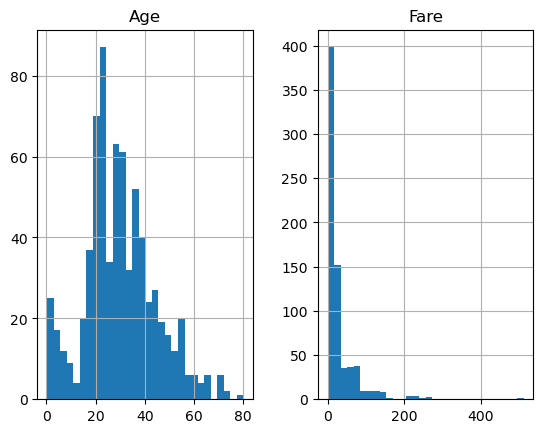

In [12]:
X_train[['Age', 'Fare']].hist(bins=30)
plt.show()

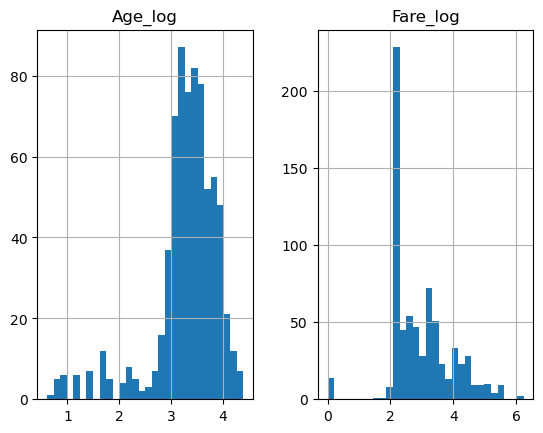

In [13]:
X_train[['Age_log', 'Fare_log']].hist(bins=30)
plt.show()

### Дискретизация количественных признаков

In [14]:
discretizer = EqualFrequencyDiscretiser(q=10)

cols_for_discretization = ['Age', 'Fare', 'Age_log', 'Fare_log']
new_names = [col + '_discr' for col in cols_for_discretization]

X_train[new_names] = discretizer.fit_transform(X_train[cols_for_discretization])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_na,Cabin_na,Age_log,Fare_log,Age_discr,Fare_discr,Age_log_discr,Fare_log_discr
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,1,1,3.347093,4.051712,4,8,4,8
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,1,1,3.153590,0.000000,2,0,2,0
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,1,0,4.014941,5.406181,9,9,9,9
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,0,1,2.966303,2.336987,1,3,1,3
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,0,1,3.478776,3.305054,5,6,5,6


### Вычисление статистик для категориальных переменных

In [15]:
def count_stats(X, y=None, cat_features=None, num_features=None, func=None):
    if cat_features is None:
        cat_cols = X.select_dtypes(include='object').columns
    else:
        cat_cols = cat_features
    
    if num_features is None:
        num_cols = X.select_dtypes(exclude='object').columns
    else:
        num_cols = num_features
        
    if func is None:
        stats = ['mean']
    else:
        stats = list(func)
        
        
    res = X.copy()
    
    for cat in cat_cols:
        for stat in stats:
            name = [f"{stat}_{num_col}_by_{cat}" for num_col in num_cols]
            res[name] = (
                X
                .groupby(by=cat)
                [num_cols]
                .transform(stat)
            )
    
    return res

In [16]:
X_train = count_stats(
    X_train, 
    cat_features=['Pclass', 'Sex', 'Title'], 
    num_features=['Age', 'Fare'],
)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,...,Age_discr,Fare_discr,Age_log_discr,Fare_log_discr,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,...,4,8,4,8,26.972302,13.660751,30.875098,24.439677,32.057039,23.452982
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,...,2,0,2,0,29.612200,20.810139,30.875098,24.439677,32.057039,23.452982
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,...,9,9,9,9,37.049240,82.999075,30.875098,24.439677,32.057039,23.452982
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,...,1,3,1,3,26.972302,13.660751,28.267787,45.209109,35.598131,47.532593
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,...,5,6,5,6,29.612200,20.810139,28.267787,45.209109,35.598131,47.532593


In [17]:
X_train = count_stats(
    X_train, 
    cat_features=['Pclass'], 
    num_features=['Pclass'],
    func=['count'],
)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,...,Fare_discr,Age_log_discr,Fare_log_discr,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,...,8,4,8,26.972302,13.660751,30.875098,24.439677,32.057039,23.452982,391
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,...,0,2,0,29.612200,20.810139,30.875098,24.439677,32.057039,23.452982,150
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,...,9,9,9,37.049240,82.999075,30.875098,24.439677,32.057039,23.452982,171
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,...,3,1,3,26.972302,13.660751,28.267787,45.209109,35.598131,47.532593,391
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,...,6,5,6,29.612200,20.810139,28.267787,45.209109,35.598131,47.532593,150


In [18]:
X_train = count_stats(
    X_train, 
    cat_features=['Ticket'], 
    num_features=['Ticket'],
    func=['count'],
)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,...,Age_log_discr,Fare_log_discr,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass,count_Ticket_by_Ticket
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,...,4,8,26.972302,13.660751,30.875098,24.439677,32.057039,23.452982,391,6
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,...,2,0,29.612200,20.810139,30.875098,24.439677,32.057039,23.452982,150,1
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,...,9,9,37.049240,82.999075,30.875098,24.439677,32.057039,23.452982,171,1
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,...,1,3,26.972302,13.660751,28.267787,45.209109,35.598131,47.532593,391,1
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,...,5,6,29.612200,20.810139,28.267787,45.209109,35.598131,47.532593,150,2


In [19]:
X_train = count_stats(
    X_train, 
    cat_features=['Cabin'], 
    num_features=['Cabin'],
    func=['count'],
)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,...,Fare_log_discr,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass,count_Ticket_by_Ticket,count_Cabin_by_Cabin
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,...,8,26.972302,13.660751,30.875098,24.439677,32.057039,23.452982,391,6,552
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,...,0,29.612200,20.810139,30.875098,24.439677,32.057039,23.452982,150,1,552
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,...,9,37.049240,82.999075,30.875098,24.439677,32.057039,23.452982,171,1,1
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,...,3,26.972302,13.660751,28.267787,45.209109,35.598131,47.532593,391,1,552
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,...,6,29.612200,20.810139,28.267787,45.209109,35.598131,47.532593,150,2,552


In [20]:
X_train = count_stats(
    X_train, 
    cat_features=['Title'], 
    num_features=['Title'],
    func=['count'],
)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,...,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass,count_Ticket_by_Ticket,count_Cabin_by_Cabin,count_Title_by_Title
692,3,male,27.0,0,0,1601,56.4958,unknown,S,mr,...,26.972302,13.660751,30.875098,24.439677,32.057039,23.452982,391,6,552,412
481,2,male,22.0,0,0,239854,0.0000,unknown,S,mr,...,29.612200,20.810139,30.875098,24.439677,32.057039,23.452982,150,1,552,412
527,1,male,54.0,0,0,PC 17483,221.7792,C95,S,mr,...,37.049240,82.999075,30.875098,24.439677,32.057039,23.452982,171,1,1,412
855,3,female,18.0,0,1,392091,9.3500,unknown,S,mrs,...,26.972302,13.660751,28.267787,45.209109,35.598131,47.532593,391,1,552,107
801,2,female,31.0,1,1,C.A. 31921,26.2500,unknown,S,mrs,...,29.612200,20.810139,28.267787,45.209109,35.598131,47.532593,150,2,552,107


In [21]:
train_pool = Pool(
    data=X_train,
    label=y_train, 
    cat_features=['Title', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked'],
)

model_params = dict(
    loss_function = metrics.Logloss(),
    custom_loss=[metrics.Accuracy(), metrics.AUC()],
)

cv_data = cv(
    pool=train_pool, 
    params=model_params, 
    logging_level='Silent', 
    plot=True,
    nfold=CV,
)

best_id = np.argmax(cv_data['test-Accuracy-mean'])

print(f"Best mean accuracy: {np.round(cv_data['test-Accuracy-mean'][best_id], 3)}")
print(f"Accuracy std: {np.round(cv_data['test-Accuracy-std'][best_id], 4)}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best mean accuracy: 0.843
Accuracy std: 0.0398


In [51]:
mask = np.triu(np.ones_like(X_train.select_dtypes(exclude='object').corr(), dtype=float))
mask[mask < 1] = np.nan

corr_matrix = X_train.select_dtypes(exclude='object').corr() #* mask

# correlations = (
#     corr_matrix
#     .stack()
#     .reset_index()
#     .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'corr'})
#     .query("feature_1 != feature_2")
#     .sort_values(by='corr', key=abs, ascending=False)
# )

# correlations

In [52]:
corr_matrix

,Pclass,Age,SibSp,Parch,Fare,Age_na,Cabin_na,Age_log,Fare_log,Age_discr,...,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass,count_Ticket_by_Ticket,count_Cabin_by_Cabin,count_Title_by_Title
Pclass,1.000000,-0.278932,0.097900,0.040467,-0.556540,0.144011,0.712738,-0.225159,-0.640571,-0.289588,...,-0.972514,-0.924574,0.145052,-0.145052,-0.151046,-0.157622,0.889138,0.008959,0.712956,0.166313
Age,-0.278932,1.000000,-0.237596,-0.157729,0.086710,0.020087,-0.182270,0.895668,0.073846,0.954007,...,0.286815,0.283338,0.086814,-0.086814,0.468608,-0.107492,-0.217446,-0.201440,-0.182448,0.166193
SibSp,0.097900,-0.237596,1.000000,0.392269,0.127011,0.021721,0.056749,-0.294044,0.290430,-0.217528,...,-0.089680,-0.081469,-0.100430,0.100430,-0.321545,0.179698,0.097914,0.587299,0.056819,-0.271275
Parch,0.040467,-0.157729,0.392269,1.000000,0.177235,-0.125457,-0.022209,-0.247870,0.308819,-0.122093,...,-0.040641,-0.039519,-0.256527,0.256527,-0.207287,0.324146,0.033452,0.544626,-0.022086,-0.344550
Fare,-0.556540,0.086710,0.127011,0.177235,1.000000,-0.086929,-0.463055,0.065798,0.789199,0.093319,...,0.594644,0.601942,-0.206986,0.206986,-0.049080,0.213964,-0.389884,0.303254,-0.463179,-0.193028
Age_na,0.144011,0.020087,0.021721,-0.125457,-0.086929,1.000000,0.126218,0.043110,-0.158069,0.010374,...,-0.105429,-0.076494,0.072069,-0.072069,0.012314,-0.092480,0.196097,-0.049774,0.126175,0.115879
Cabin_na,0.712738,-0.182270,0.056749,-0.022209,-0.463055,0.126218,1.000000,-0.131128,-0.528679,-0.190209,...,-0.762175,-0.771928,0.169758,-0.169758,-0.026102,-0.166956,0.498053,-0.004461,0.999999,0.159240
Age_log,-0.225159,0.895668,-0.294044,-0.247870,0.065798,0.043110,-0.131128,1.000000,0.012916,0.848403,...,0.236118,0.236235,0.076621,-0.076621,0.594532,-0.142831,-0.166495,-0.259707,-0.131335,0.268582
Fare_log,-0.640571,0.073846,0.290430,0.308819,0.789199,-0.158069,-0.528679,0.012916,1.000000,0.095528,...,0.662018,0.656158,-0.282552,0.282552,-0.073508,0.316813,-0.492798,0.428763,-0.528790,-0.320621
Age_discr,-0.289588,0.954007,-0.217528,-0.122093,0.093319,0.010374,-0.190209,0.848403,0.095528,1.000000,...,0.291044,0.283152,0.072534,-0.072534,0.429531,-0.079334,-0.238977,-0.169383,-0.190342,0.123560


In [53]:
corr_matrix * mask

,Pclass,Age,SibSp,Parch,Fare,Age_na,Cabin_na,Age_log,Fare_log,Age_discr,...,mean_Age_by_Pclass,mean_Fare_by_Pclass,mean_Age_by_Sex,mean_Fare_by_Sex,mean_Age_by_Title,mean_Fare_by_Title,count_Pclass_by_Pclass,count_Ticket_by_Ticket,count_Cabin_by_Cabin,count_Title_by_Title
Pclass,1.0,-0.278932,0.097900,0.040467,-0.556540,0.144011,0.712738,-0.225159,-0.640571,-0.289588,...,-0.972514,-0.924574,0.145052,-0.145052,-0.151046,-0.157622,0.889138,0.008959,0.712956,0.166313
Age,NaN,1.000000,-0.237596,-0.157729,0.086710,0.020087,-0.182270,0.895668,0.073846,0.954007,...,0.286815,0.283338,0.086814,-0.086814,0.468608,-0.107492,-0.217446,-0.201440,-0.182448,0.166193
SibSp,NaN,NaN,1.000000,0.392269,0.127011,0.021721,0.056749,-0.294044,0.290430,-0.217528,...,-0.089680,-0.081469,-0.100430,0.100430,-0.321545,0.179698,0.097914,0.587299,0.056819,-0.271275
Parch,NaN,NaN,NaN,1.000000,0.177235,-0.125457,-0.022209,-0.247870,0.308819,-0.122093,...,-0.040641,-0.039519,-0.256527,0.256527,-0.207287,0.324146,0.033452,0.544626,-0.022086,-0.344550
Fare,NaN,NaN,NaN,NaN,1.000000,-0.086929,-0.463055,0.065798,0.789199,0.093319,...,0.594644,0.601942,-0.206986,0.206986,-0.049080,0.213964,-0.389884,0.303254,-0.463179,-0.193028
Age_na,NaN,NaN,NaN,NaN,NaN,1.000000,0.126218,0.043110,-0.158069,0.010374,...,-0.105429,-0.076494,0.072069,-0.072069,0.012314,-0.092480,0.196097,-0.049774,0.126175,0.115879
Cabin_na,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.131128,-0.528679,-0.190209,...,-0.762175,-0.771928,0.169758,-0.169758,-0.026102,-0.166956,0.498053,-0.004461,0.999999,0.159240
Age_log,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.012916,0.848403,...,0.236118,0.236235,0.076621,-0.076621,0.594532,-0.142831,-0.166495,-0.259707,-0.131335,0.268582
Fare_log,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.095528,...,0.662018,0.656158,-0.282552,0.282552,-0.073508,0.316813,-0.492798,0.428763,-0.528790,-0.320621
Age_discr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,0.291044,0.283152,0.072534,-0.072534,0.429531,-0.079334,-0.238977,-0.169383,-0.190342,0.123560
